
# Forecast

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Concatenate, \
                                    LSTM, Activation, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow_addons.layers import SpectralNormalization as SN

In [2]:
%matplotlib inline
file_name = 'forecast_comparison'
dir_name = file_name + '_dir'
ckpt_dir = dir_name + '/ckpt'
os.mkdir(dir_name)
os.mkdir(ckpt_dir)

In [3]:
data = np.load('../../data/processed/dccgan_full_generated_data.npz')
gen_electrical_data = data['electrical_data']
gen_labels = data['labels']

In [4]:
data = np.load('../../data/processed/full_data.npz')
electrical_data = data['electrical_data'][:500]
labels = data['labels'][:500]

## Split Data

In [5]:
def split_data(data, labels):
    train_factor, val_factor = 0.8, 0.1
    train_limit, val_limit = int(len(data) * train_factor), int(len(data) * (train_factor + val_factor))
    train_data, train_labels = data[:train_limit], labels[:train_limit]
    val_data, val_labels = data[train_limit:val_limit], labels[train_limit:val_limit]
    test_data, test_labels = data[val_limit:], labels[val_limit:]
    return train_data, train_labels, val_data, val_labels, test_data, test_labels

In [6]:
_, _, _, _, test_data, test_labels = split_data(electrical_data, labels)
gen_train_data, gen_train_labels, gen_val_data, gen_val_labels, _, _ = split_data(gen_electrical_data, gen_labels)

## Building the Model

In [7]:
early_stopping_monitor = EarlyStopping(patience=3)
data_length = 720 # One month of data
nr_labels = 6 # from labels + timestamp
emb_input_dim = 28 + electrical_data.shape[1] - data_length + 1 # Added values are for timestamp
emb_output_dim = 32
batch_size = 128

In [8]:
def conv_block(kernel_size, filters, padding, input_layer):
    sn_conv_1d = SN(Conv1D(kernel_size=kernel_size, filters=filters, padding=padding))(input_layer)
    bn = BatchNormalization()(sn_conv_1d)
    act = Activation('relu')(bn)
    mp_1d = MaxPooling1D()(act)
    res = Dropout(0.2)(mp_1d)
    return res

In [9]:
def create_model():
    sampled_data = Input((data_length, electrical_data.shape[2]), name='input_1')
    sampled_labels = Input((nr_labels,), name='input_2')
    label_embedding = SN(Embedding(emb_input_dim, emb_output_dim, input_length=nr_labels))(sampled_labels)
    flatten_embedding = Flatten()(label_embedding)
    dense_embedding = SN(Dense(64))(flatten_embedding)
    conv1 = conv_block((3), 128, 'same', sampled_data)
    conv2 = conv_block((5), 128, 'same', sampled_data)
    conv3 = conv_block((7), 128, 'same', sampled_data)
    conc_convs = Concatenate(axis=-1)([conv1, conv2, conv3])
    lstm1 = LSTM(128, return_sequences=True)(conc_convs)
    bn1 = BatchNormalization()(lstm1)
    lstm2 = LSTM(128)(bn1)
    bn2 = BatchNormalization()(lstm2)
    conc_all = Concatenate(axis=1)([bn2, dense_embedding])
    dense_final = SN(Dense(128, activation='relu'))(conc_all)
    res = SN(Dense(1, activation='tanh'))(dense_final)
    model = Model([sampled_data, sampled_labels], res, name='C-RNN')
    model.compile(optimizer = Adam(1e-3, 0.5, 0.9), loss = 'mse', metrics = ['mae', 'mape'])
    return model

## Define Generator

In [10]:
def generator_wrapper(data, labels, batch_size):
    def generator():
        while True:
            indexes = np.random.randint(0, data.shape[0], batch_size)
            sampled_data = data[indexes]
            hours = np.random.randint(0, data.shape[1] - data_length, batch_size)
            X = np.array([x[h:h + data_length] for x, h in zip(sampled_data, hours)])
            y = np.array([x[h + data_length, 0] for x, h in zip(sampled_data, hours)])
            l = np.array([np.concatenate((l, h), axis=-1) for l, h in zip(labels[indexes], np.expand_dims(hours, -1))])
            yield {'input_1': X, 'input_2': l}, y
    return generator

## Define Dataset

In [11]:
def dataset_from_generator(data, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(generator_wrapper(data, labels, batch_size), output_signature=\
                                             ({'input_1': tf.TensorSpec(shape=(batch_size, data_length, 6), dtype=tf.float64), \
                                              'input_2': tf.TensorSpec(shape=(batch_size, nr_labels), dtype=tf.int32)}, \
                                              tf.TensorSpec(shape=(batch_size), dtype=tf.float64)))
    #dataset = dataset.batch(batch_size)
    return dataset

## Trainging the Model

In [24]:
gen_model = create_model()
gen_history = gen_model.fit(dataset_from_generator(gen_train_data, gen_train_labels, batch_size), epochs=100, steps_per_epoch=200, \
                    validation_data=dataset_from_generator(gen_val_data, gen_val_labels, batch_size), validation_steps=50, \
                    callbacks=[early_stopping_monitor])

Epoch 1/100
200/200 [==============================] - 33s 148ms/step - loss: 0.0369 - mae: 0.1317 - mape: 120.2472 - val_loss: 0.1457 - val_mae: 0.3358 - val_mape: 134.0239
Epoch 2/100
200/200 [==============================] - 28s 142ms/step - loss: 0.0070 - mae: 0.0657 - mape: 73.0364 - val_loss: 0.0568 - val_mae: 0.2148 - val_mape: 65.5990
Epoch 3/100
200/200 [==============================] - 29s 143ms/step - loss: 0.0042 - mae: 0.0507 - mape: 184.7722 - val_loss: 0.0064 - val_mae: 0.0681 - val_mape: 40.2251
Epoch 4/100
200/200 [==============================] - 29s 143ms/step - loss: 0.0034 - mae: 0.0454 - mape: 41.5130 - val_loss: 0.0029 - val_mae: 0.0414 - val_mape: 26.7096
Epoch 5/100
200/200 [==============================] - 29s 144ms/step - loss: 0.0030 - mae: 0.0426 - mape: 35.2037 - val_loss: 0.0018 - val_mae: 0.0354 - val_mape: 55.0521
Epoch 6/100
200/200 [==============================] - 29s 145ms/step - loss: 0.0024 - mae: 0.0381 - mape: 51.9657 - val_loss: 0.0030 - v

In [49]:
gen_model.save_weights(ckpt_dir + '/gen_weights.ckpt')

## Test the Model

### TSTR

In [32]:
gen_model_eval_3 = gen_model.evaluate(dataset_from_generator(test_data, test_labels, batch_size), steps=1000)

1000/1000 [==============================] - 63s 63ms/step - loss: 0.0100 - mae: 0.0731 - mape: 381.03610s - loss: 0.0099 - mae:


## Load already computed metrics

In [14]:
rest_metrics = np.load('forecast_metrics&evals.npz')

## Show Results

In [15]:
model_eval = rest_metrics['trtr']
wgen_model_eval = rest_metrics['tstr']

In [48]:
print(model_eval)
print(gen_model_eval)
print(wgen_model_eval)

[6.37094537e-03 5.81483394e-02 1.05123657e+03]
[0.01333446286, 0.09746634961, 889.52771]
[1.45346681e-02 8.84554461e-02 1.45487122e+02]


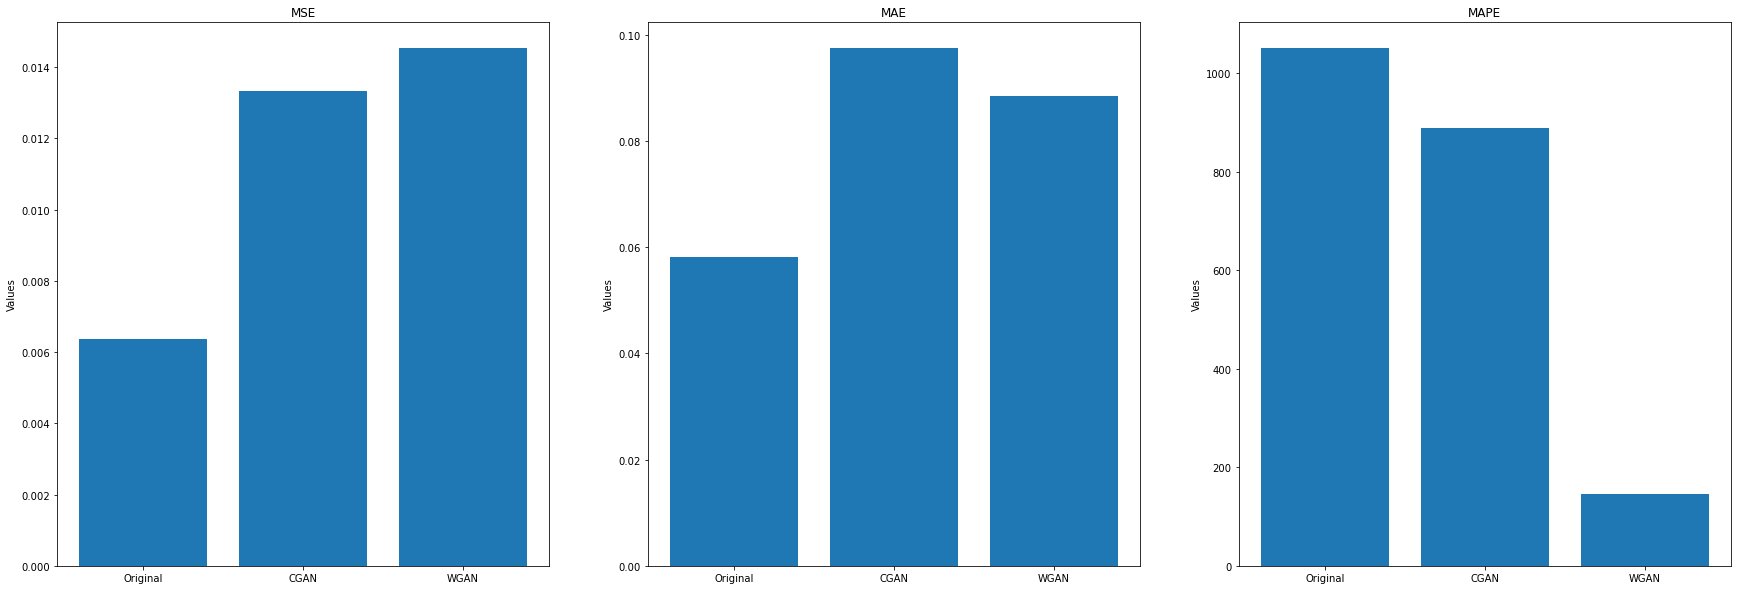

In [50]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(30, 10)
for i, metric in enumerate(['loss', 'mae', 'mape']):
    title = metric if metric != 'loss' else 'mse'
    ax = axs[i]
    ax.bar(['Original', 'CGAN', 'WGAN'], [model_eval[i], gen_model_eval[i], wgen_model_eval[i]])
    ax.title.set_text(title.upper())
    ax.set_ylabel('Values')